In [34]:
from sklearn.linear_model import LogisticRegression
import numpy as np
import os
from embeddings import get_embeddings
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
import polars as pl
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## no count balance & no relative balance

In [35]:
# column_name = ['noisy', 'abstract', 'paint'][0]
# 
# csv_path = '/Users/yuda/PycharmProjects/matching_arts_v3/data/eli_votes.csv'
# images_folder = '/Users/yuda/Desktop/vs_code_projects/data/'
# 
# # Load and filter
# df = pl.read_csv(csv_path)
# 
# # Only keep rows where filled is True
# df = df.filter(pl.col("filled") == True)
# # just in case:
# df = df.filter(pl.col(column_name).is_not_null())
# 
# 
# # Create full image paths
# df = df.with_columns([
#     (pl.col("image_id").cast(str) + ".jpg").alias("file_name"),
#     (pl.lit(images_folder) + "/" + pl.col("image_id").cast(str) + ".jpg").alias("file_path")
# ])
# 
# # Shuffle
# df = df.sample(frac=1.0, seed=42)
# 
# p = 0.8
# split_idx = int(len(df) * p)
# train_df = df[:split_idx]
# test_df = df[split_idx:]
# 
# # Final lists
# X_train_names = train_df["file_path"].to_list()
# y_train_list = train_df[column_name].cast(int).to_list()
# 
# X_test_names = test_df["file_path"].to_list()
# y_test_list = test_df[column_name].cast(int).to_list()

## relative balance, no count balance

In [36]:
# column_name = ['noisy', 'abstract', 'paint'][0]
# 
# csv_path = '/Users/yuda/PycharmProjects/matching_arts_v3/data/eli_votes.csv'
# images_folder = '/Users/yuda/Desktop/vs_code_projects/data/'
# 
# # Load and filter
# df = pl.read_csv(csv_path)
# 
# # Filter to only filled and non-null target
# df = df.filter(
#     (pl.col("filled") == True) &
#     (pl.col(column_name).is_not_null())
# )
# 
# # Add file paths
# df = df.with_columns([
#     (pl.col("image_id").cast(str) + ".jpg").alias("file_name"),
#     (pl.lit(images_folder) + "/" + pl.col("image_id").cast(str) + ".jpg").alias("file_path")
# ])
# 
# # Convert to lists
# X_all = df["file_path"].to_list()
# y_all = df[column_name].cast(int).to_list()
# 
# # Stratified split
# X_train_names, X_test_names, y_train_list, y_test_list = train_test_split(
#     X_all, y_all, train_size=0.8, stratify=y_all, random_state=42
# )

## count balance

In [38]:
column_name = ['noisy', 'abstract', 'paint'][0]

csv_path = '/Users/yuda/PycharmProjects/matching_arts_v3/data/eli_votes.csv'
images_folder = '/Users/yuda/Desktop/vs_code_projects/data/'

# Load and filter
df = pl.read_csv(csv_path)

# Filter to only filled and non-null target
df = df.filter(
    (pl.col("filled") == True) &
    (pl.col(column_name).is_not_null())
)

# Add file paths
df = df.with_columns([
    (pl.col("image_id").cast(str) + ".jpg").alias("file_name"),
    (pl.lit(images_folder) + "/" + pl.col("image_id").cast(str) + ".jpg").alias("file_path")
])

# Convert to lists
X_all = df["file_path"].to_list()
y_all = df[column_name].cast(int).to_list()

# Ensure equal class distribution by balancing the classes
unique_classes = np.unique(y_all)
min_class_count = min([y_all.count(i) for i in unique_classes])  # Find the class with the minimum count

# Create balanced dataset by sampling from each class
X_balanced = []
y_balanced = []

for class_label in unique_classes:
    # Get indices for each class
    indices = [i for i, label in enumerate(y_all) if label == class_label]
    
    # Randomly sample the same number of examples for each class based on the smallest class count
    sampled_indices = np.random.choice(indices, min_class_count, replace=False)
    
    # Add the sampled data to the balanced list
    X_balanced.extend([X_all[i] for i in sampled_indices])
    y_balanced.extend([y_all[i] for i in sampled_indices])

# Now we have a balanced dataset
X_balanced = np.array(X_balanced)
y_balanced = np.array(y_balanced)

# Stratified split of the balanced data
X_train_names, X_test_names, y_train_list, y_test_list = train_test_split(
    X_balanced, y_balanced, train_size=0.8, stratify=y_balanced, random_state=42
)

print(f"Train size: {len(X_train_names)}")
print(f"Test size: {len(X_test_names)}")
print(f"Train class distribution: {dict(zip(*np.unique(y_train_list, return_counts=True)))}")
print(f"Test class distribution: {dict(zip(*np.unique(y_test_list, return_counts=True)))}")


Train size: 280
Test size: 70
Train class distribution: {1: 56, 2: 56, 3: 56, 4: 56, 5: 56}
Test class distribution: {1: 14, 2: 14, 3: 14, 4: 14, 5: 14}


In [39]:
X_train_list = get_embeddings(X_train_names)
X_test_list = get_embeddings(X_test_names)

X_train: np.ndarray = np.array(X_train_list)
y_train: np.ndarray = np.array(y_train_list)

X_test: np.ndarray = np.array(X_test_list)
y_test: np.ndarray = np.array(y_test_list)

In [40]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
predictions = clf.predict(X_test)
predictions

array([4, 3, 2, 1, 2, 4, 2, 5, 5, 1, 4, 5, 3, 3, 4, 1, 4, 5, 2, 4, 1, 1,
       5, 2, 1, 2, 3, 4, 2, 4, 1, 5, 1, 2, 2, 2, 3, 4, 3, 5, 1, 3, 2, 3,
       1, 2, 1, 4, 1, 4, 2, 5, 4, 1, 3, 3, 2, 1, 2, 2, 2, 4, 5, 5, 3, 1,
       3, 4, 3, 3])

In [41]:
clf.predict_proba(X_test)

array([[0.12676853, 0.15340385, 0.23690308, 0.25990324, 0.2230213 ],
       [0.17649356, 0.18850856, 0.28522471, 0.1832701 , 0.16650306],
       [0.09614243, 0.25337239, 0.20242164, 0.20657904, 0.24148451],
       [0.31911941, 0.16779988, 0.22728571, 0.1679164 , 0.1178786 ],
       [0.12507379, 0.27907871, 0.22416676, 0.1717001 , 0.19998064],
       [0.05658804, 0.14570501, 0.23072425, 0.36414135, 0.20284134],
       [0.12880587, 0.32025021, 0.26991966, 0.14403811, 0.13698616],
       [0.1043712 , 0.13546132, 0.26044317, 0.1952939 , 0.30443041],
       [0.10025795, 0.15345225, 0.18895822, 0.25305649, 0.30427509],
       [0.35019499, 0.2158681 , 0.17962984, 0.13811641, 0.11619066],
       [0.07248974, 0.1561906 , 0.17024536, 0.31107659, 0.28999772],
       [0.11472197, 0.18507466, 0.21659489, 0.18573655, 0.29787193],
       [0.2369483 , 0.14513197, 0.27416284, 0.14608739, 0.1976695 ],
       [0.18940944, 0.13535173, 0.23116866, 0.22225292, 0.22181725],
       [0.14267022, 0.14490729, 0.

In [42]:

def show_images(images_list, prediction, target):
    """
    Display images with their predictions and target labels.
    Supports both image file paths and numpy arrays.
    """

    num_images = len(images_list)
    cols = min(5, num_images)
    rows = (num_images // cols) + (num_images % cols > 0)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    axes = axes.flatten() if num_images > 1 else [axes]

    for i in range(num_images):
        # Load image if it's a file path (string)
        img = Image.open(images_list[i]) if isinstance(images_list[i], str) else images_list[i]
        img = np.array(img)  # Convert to NumPy array for `imshow`

        axes[i].imshow(img, cmap="gray" if len(img.shape) == 2 else None)
        axes[i].axis("off")
        axes[i].set_title(f"Pred: {prediction[i]}\nTarget: {target[i]}", fontsize=10)

    plt.tight_layout()
    plt.show()

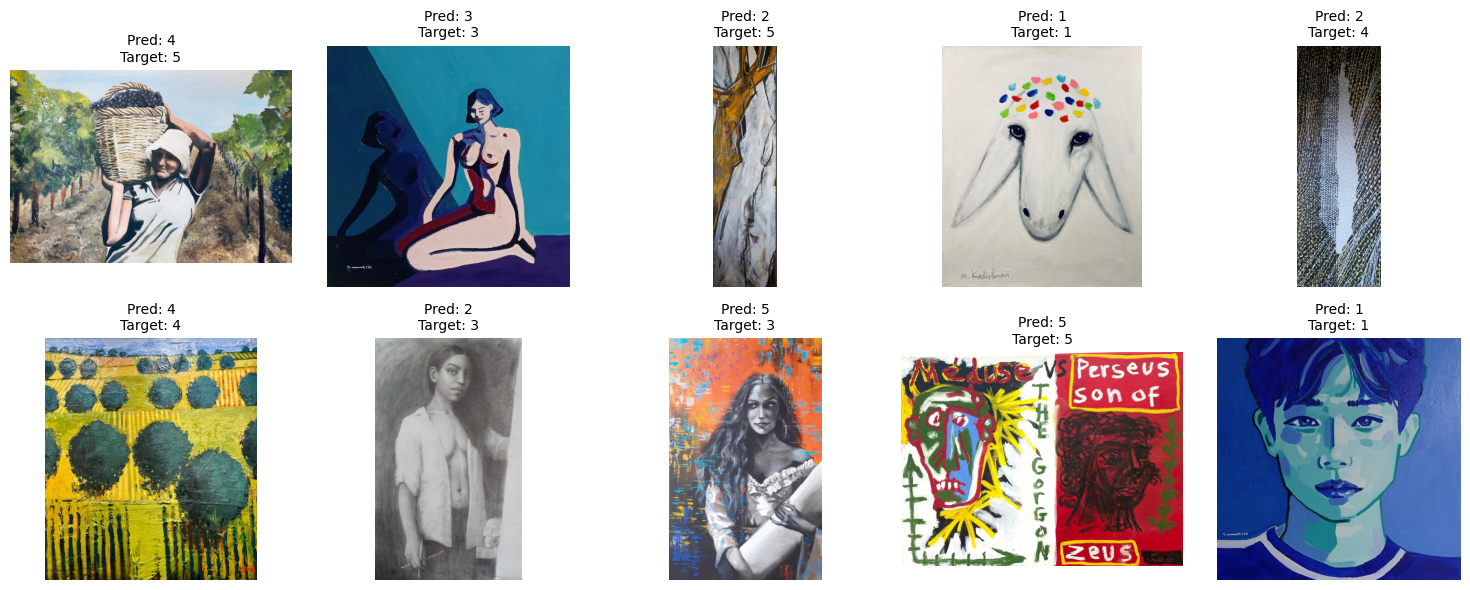

In [43]:
show_images(X_test_names[:10], list(predictions)[:10], y_test_list[:10])

In [44]:
accuracy_score(predictions, y_test)

0.37142857142857144

In [45]:

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           1       0.60      0.64      0.62        14
           2       0.29      0.36      0.32        14
           3       0.14      0.14      0.14        14
           4       0.43      0.43      0.43        14
           5       0.40      0.29      0.33        14

    accuracy                           0.37        70
   macro avg       0.37      0.37      0.37        70
weighted avg       0.37      0.37      0.37        70



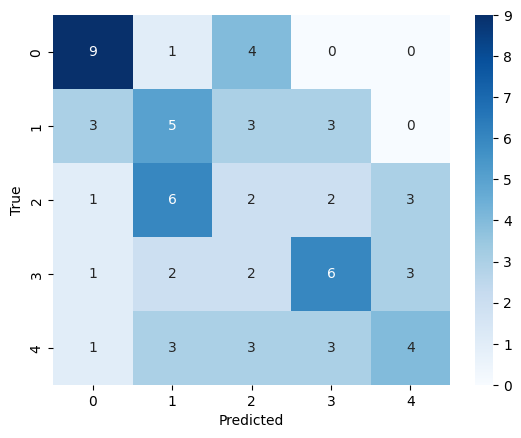

In [46]:

cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [48]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate the MSE and MAE for the ordinal predictions
mse = mean_squared_error(y_test, predictions)  # y_pred: model's predicted classes
mae = mean_absolute_error(y_test, predictions)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

Mean Squared Error (MSE): 1.9857142857142858
Mean Absolute Error (MAE): 1.0142857142857142


In [49]:
from sklearn.metrics import cohen_kappa_score

# Assuming y_pred is your predicted labels and y_test_list is your true labels
kappa = cohen_kappa_score(y_test, predictions, weights='quadratic')  # 'quadratic' accounts for the distance between classes
print(f"Weighted Kappa: {kappa}")


Weighted Kappa: 0.48708487084870844


In [47]:
train_predictions = clf.predict(X_train)
accuracy_score(train_predictions, y_train)

0.7321428571428571

In [10]:
# 0.47, 0.64
# 0.63, 0.68
# 0.52, 0.56